In [1]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib qt')   
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.motion_correction import motion_correct_oneP_rigid, motion_correct_oneP_nonrigid
import os
import cv2
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour

try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')
import bokeh.plotting as bpl
bpl.output_notebook()

/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading BokehJS ...

In [2]:
cd ~/Data

/home/fpbatta/Data


### loading one file

In [15]:
fnames = ['recording_20170710_120637-001.tif']
frate = 10 # movie frame rate
gSig = 5   # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 15  # average diameter of a neuron
do_motion_correction = True

In [4]:
m_orig = cm.load_movie_chain(fnames[:1])

100%|██████████| 1/1 [00:10<00:00, 10.45s/it]


In [5]:
print(type(m_orig))
m_orig.shape

<class 'caiman.base.movies.movie'>


(1349, 1080, 1440)

### spatially downsampling, cropping

Cropping mask defined by hand

In [6]:
m_ds = m_orig.resize(0.5, 0.5, 1.)
m_ds.shape

reshaping along x and y
(720, 540)


(1349, 540, 720)

In [7]:
m_crop = m_ds.crop(0, 140, 0, 120).copy()

In [8]:
m_crop.shape

(1349, 400, 600)

In [9]:
m_crop.save('crop1.tif')

.tif
tifffile package not found, using skimage instead for imsave


In [4]:
m_crop = cm.load_movie_chain(['crop1.tif'])

100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


In [10]:
ms = m_crop
_, size_y, size_x = ms.shape
p = bpl.figure(x_range=(0,size_x), y_range=(0,size_y))
p.image(image=[m_crop[0,:,:]], x=0, y=0, dw=size_x, dh=size_y, palette='Greys256')
bpl.show(p)
#plt.imshow(m_ds[0,:,:])

In [11]:
offset_mov = -np.min(m_crop[:100]).astype(np.float32)

In [12]:
m_crop.play(gain=1.5, fr=30, magnification=1, offset=offset_mov)

In [13]:
try:
    dview.terminate() # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=8,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
0
0
0
0
10
0
0
10
0
0
20
10
10
20
10
10
10
10
30
20
20
30
20
20
20
0
30
20
0
30
10
30
0
30
30
10
30
20
0
10
20
0
0
0
30
0
20
10
30
0
10
10
10
30
10
0
10
20
0
20
20
20
20
30
10
30
10
20
20
0
30
30
10
30
30
20
30
0
20
30
0
0
10
0
30
0
0
10
0
0
10
20
10
10
10
10
10
20
20
20
20
30
20
30
20
30
20
30
30
0
0
30
30
30
10
10
0
20
20
10
30
30
20
0
30
10
20
30


In [16]:
fnames = ['crop1.tif']

Rigid Motion Correction
2.6018257
-0.5723754787445069


/home/fpbatta/src/extern/CaImAn_stable/caiman/base/movies.py:260: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/fpbatta/src/extern/CaImAn_stable/caiman/base/movies.py:279: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')


Frame 100
cubic interpolation
Frame 100
-0.5723754787445069
Frame 100
cubic interpolation
Frame 100
-0.5723754787445069
Frame 100
cubic interpolation
Frame 100
Adding to movie 2.6018257
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
0.1307216
crop1_rig__d1_400_d2_600_d3_1_order_F_frames_1349_.mmap
loading in memory
mmap


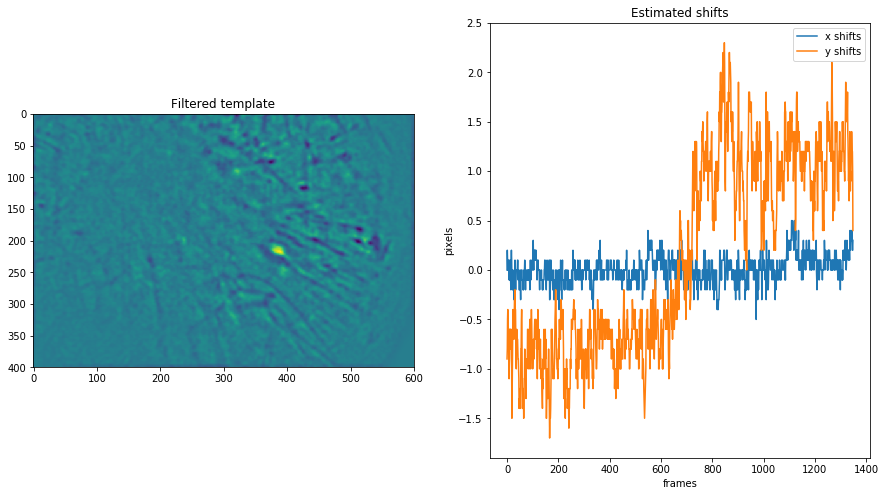

In [17]:
if do_motion_correction:
    mc = motion_correct_oneP_rigid(fnames[0],                        # name of file to motion correct
                               gSig_filt = [gSig]*2,                 # size of filter, xhange this one if algorithm does not work 
                               max_shifts = [5,5],                   # maximum shifts allowed in each direction 
                               dview=dview, 
                               splits_rig = 40,                      # number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100) 
                               save_movie = True)                    # whether to save movie in memory mapped format
    
    new_templ = mc.total_template_rig
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)    
    plt.title('Filtered template')
    plt.imshow(new_templ)       #% plot template
    plt.subplot(1,2,2)
    plt.title('Estimated shifts')
    plt.plot(mc.shifts_rig)     #% plot rigid shifts
    plt.legend(['x shifts', 'y shifts'])
    plt.xlabel('frames')
    plt.ylabel('pixels')
    
    bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)     #borders to eliminate from movie because of motion correction        
    fname_new = cm.save_memmap(mc.fname_tot_rig, base_name='memmap_', order = 'C') # transforming memoruy mapped file in C order (efficient to perform computing)
else:
    #% create memory mappable file
    fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C')

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

generating template by rigid motion correction
Rigid Motion Correction
1.3964224
-0.3875322353839874


/home/fpbatta/src/extern/CaImAn_stable/caiman/base/movies.py:260: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/fpbatta/src/extern/CaImAn_stable/caiman/base/movies.py:279: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')


cubic interpolation
-0.3875322353839874
cubic interpolation
-0.3875322353839874
cubic interpolation
Adding to movie 1.3964224
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
0.2631263
Adding to movie 1.3964224
0
saving mmap of crop1.tif
**** MOVIE NOT SAVED BECAUSE num_splits is not None ****
** Startting parallel motion correction **
** Finished parallel motion correction **
Adding to movie 1.3964224
0
saving mmap of crop1.tif
** Startting parallel motion correction **
** Finished parallel motion correction **
crop1_els__d1_400_d2_600_d3_1_order_F_frames_674_.mmap
loading in memory
mmap


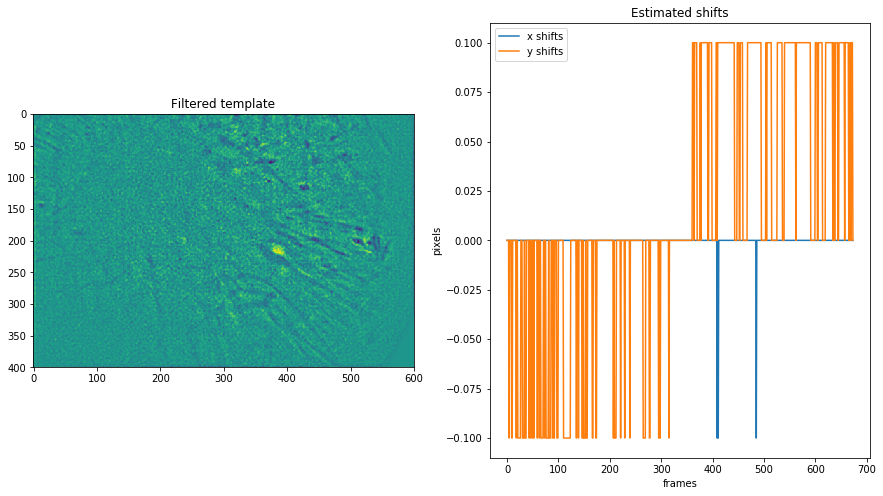

In [50]:
from caiman.motion_correction import motion_correct_oneP_nonrigid

# motion correction parameters
niter_rig = 1               # number of iterations for rigid motion correction
max_shifts = (12, 12)         # maximum allow rigid shift
strides = (96, 96)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
splits_els = 56             # for parallelization split the movies in  num_splits chuncks across time
upsample_factor_grid = 4    # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3     # maximum deviation allowed for patch with respect to rigid shifts
if do_motion_correction:
    mc_pw = motion_correct_oneP_nonrigid(fnames[0],                        # name of file to motion correct
                               gSig_filt=[gSig]*2,                 # size of filter, xhange this one if algorithm does not work 
                               max_shifts=max_shifts,                   # maximum shifts allowed in each direction
                               strides=strides,
                               overlaps=overlaps,
                               splits_els=splits_els,
                               upsample_factor_grid=upsample_factor_grid,
                               max_deviation_rigid=max_deviation_rigid,
                               dview=dview, 
                               splits_rig = 40,                      # number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100) 
                               save_movie = True)                    # whether to save movie in memory mapped format
    
    new_templ = mc_pw.total_template_rig
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)    
    plt.title('Filtered template')
    plt.imshow(new_templ)       #% plot template
    plt.subplot(1,2,2)
    plt.title('Estimated shifts')
    plt.plot(mc_pw.shifts_rig)     #% plot rigid shifts
    plt.legend(['x shifts', 'y shifts'])
    plt.xlabel('frames')
    plt.ylabel('pixels')
    
    # bord_px_rig = np.ceil(np.max(mc_pw.shifts_els)).astype(np.int)     #borders to eliminate from movie because of motion correction        
    fname_new = cm.save_memmap(mc_pw.fname_tot_els, base_name='pw_memmap_', order = 'C') # transforming memoruy mapped file in C order (efficient to perform computing)
else:
    #% create memory mappable file
    fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C')

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

In [21]:
mc_pw.fname_tot_rig

[None]

In [25]:
m_rig = cm.load('crop1_rig__d1_400_d2_600_d3_1_order_F_frames_674_.mmap')

mmap


m_els = cm.load('crop1_els__d1_400_d2_600_d3_1_order_F_frames_674_.mmap')

In [14]:
m_els.play()

In [28]:
cm.concatenate([m_crop, m_rig, m_els], axis=2).play(magnification=0.8)

In [18]:
try:
    dview.terminate() # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=8,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

(1349, 81, 81)
(1349, 81, 81)
(1349, 81, 81)
(1349, 81, 81)
(1349, 81, 81)
(1349, 81, 81)
(1349, 81, 81)
using 1 processes
using 1 processes
using 1 processes
using 1 processes
using 1 processes
using 1600 pixels per process
using 1 processes
using 1600 pixels per process
using 1 processes
using 1600 pixels per process
using 1600 pixels per process
using 1600 pixels per process
using 1600 pixels per process
using 5000 block_size
using 1600 pixels per process
using 5000 block_size
using 5000 block_size
using 5000 block_size
using 5000 block_size
preprocessing ...
using 5000 block_size
preprocessing ...
using 5000 block_size
preprocessing ...
preprocessing ...
checking if missing data
preprocessing ...
preprocessing ...
checking if missing data
preprocessing ...
checking if missing data
checking if missing data
checking if missing data
checking if missing data
checking if missing data
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
c

/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


Compute Residuals
Initialization again
Compute Residuals
0 neurons have been initialized
Initialization again
In total,  1 neurons were initialized.
Compute Background


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


Compute Residuals
Compute Residuals
Initialization again
Initialization again
In total,  0 neurons were initialized.
Update Temporal
Generating residuals
0 neurons have been initialized
Compute Residuals
In total,  1 neurons were initialized.
Initialization again


/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Update Temporal
In total,  0 neurons were initialized.
entering the deconvolution 
Generating residuals
Compute Residuals
Update Temporal
stopping: overall temporal component not changing significantly
Update Spatial
Generating residuals
Initialization again
entering the deconvolution 
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
Compute Residuals
1 out of total 1 temporal components updated
computing the distance indicators
1 out of total 1 temporal components updated
Initialization again
stopping: overall temporal component not changing significantly


/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


memmaping
entering the deconvolution 
Update Spatial
stopping: overall temporal component not changing significantly
Update Spatial


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


Initializing update of Spatial Components
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
Updating Spatial Components using lasso lars
computing the distance indicators
thresholding components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
Computing residuals


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


memmaping
memmaping
--- 0.11612582206726074 seconds ---
Updating Spatial Components using lasso lars
Removing tempfiles created


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


0 neurons have been initialized
Updating Spatial Components using lasso lars
Compute Background Again
thresholding components
0 neurons have been initialized
Computing residuals
--- 0.08188605308532715 seconds ---
Removing tempfiles created
0 neurons have been initialized
In total,  1 neurons were initialized.
In total,  2 neurons were initialized.
Compute Background Again
Update Temporal


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


Update Temporal
0 neurons have been initialized
Generating residuals
In total,  2 neurons were initialized.
Update Temporal
Generating residuals
Compute Residuals
entering the deconvolution 
Initialization again
1 out of total 1 temporal components updated
entering the deconvolution 
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
In total,  3 neurons were initialized.
1 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Update Temporal
1 out of total 2 temporal components updated
Update Spatial
Generating residuals
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
Initializing update of Spatial Components
1 out of total 2 temporal components updated
1 out of total 2 temporal components updated
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
entering the deconvolution 
compu

/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


parallel dot product block size: 1000
Start product
Transposing
999
1999


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


2999
parallel dot product block size: 1000
3999
Start product
Transposing
999
1999
4999
2999
5999
3999
6560
4999
thresholding components
Computing residuals
--- 2.055785894393921 seconds ---
5999
Removing tempfiles created
6560
Compute Background Again
Estimate low rank Background


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


thresholding components
Computing residuals
--- 2.6858692169189453 seconds ---
Removing tempfiles created
parallel dot product block size: 1000
Compute Background Again
Start product
Transposing
999
1999
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
using 5000 block_size
2999
preprocessing ...
checking if missing data
checking if missing data
3999
4999
5999
6560
Estimate low rank Background


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
3999
preprocessing ...
checking if missing data
4999
5999
6560
thresholding components
Computing residuals
--- 3.095334053039551 seconds ---
Removing tempfiles created
Compute Background Again
Estimate low rank Background
thresholding components
Computing residuals
--- 3.1802918910980225 seconds ---
Removing tempfiles created
Compute Background Again
Estimate low rank Background
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


parallel dot product block size: 1000
Start product
Transposing
initializing ...
999
1999
Spatial Downsampling 1-photon
2999
Roi Extraction...
One photon initialization..
3999
4999
In total,  0 neurons were initialized.
Compute Background
5999
6560
initializing ...
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
In total,  0 neurons were initialized.
Compute Background
Compute Residuals
Initialization again
In total,  0 neurons were initialized.


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
parallel dot product block size: 1000
Updating Spatial Components using lasso lars
Start product
thresholding components
Compute Residuals
Transposing
Computing residuals
999
--- 0.08383560180664062 seconds ---
Removing tempfiles created
Initialization again
Compute Background Again
1999
thresholding components
2999
Computing residuals
thresholding components
--- 4.613458633422852 seconds ---
3999
Removing tempfiles created
Compute Background Again
Computing residuals
(1349, 81, 81)
4999
using 1 processes


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


--- 4.832905530929565 seconds ---
Removing tempfiles created
5999
using 1600 pixels per process
using 5000 block_size
0 neurons have been initialized
initializing ...
preprocessing ...
Compute Background Again
checking if missing data
6560
Spatial Downsampling 1-photon
In total,  2 neurons were initialized.
Update Temporal
Generating residuals
Roi Extraction...
One photon initialization..
entering the deconvolution 
1 out of total 2 temporal components updated
Estimate low rank Background
2 out of total 2 temporal components updated
1 out of total 2 temporal components updated
In total,  0 neurons were initialized.
Update Temporal
2 out of total 2 temporal components updated
Compute Background
stopping: overall temporal component not changing significantly
Estimate low rank Background
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance ind

/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 0.052243709564208984 seconds ---
Removing tempfiles created
thresholding components
Compute Background Again
Computing residuals
thresholding components
--- 0.597618818283081 seconds ---
Computing residuals
Removing tempfiles created
--- 0.27307605743408203 seconds ---
Compute Background Again
Removing tempfiles created
Compute Background Again


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


Estimate low rank Background
parallel dot product block size: 1000
initializing ...
Start product
Transposing
Spatial Downsampling 1-photon
Update Temporal
999
1999
Roi Extraction...
2999
One photon initialization..
3999
4999
In total,  0 neurons were initialized.
5999
Compute Background
Update Temporal
6560
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Compute Residuals
Initialization again
Generating residuals
0 neurons have been initialized
In total,  1 neurons were initialized.
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
thresholding components


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/initialization.py:1100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


Computing residuals
--- 0.5061347484588623 seconds ---
Removing tempfiles created
Compute Background Again
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
parallel dot product block size: 1000
Start product
Transposing
using 5000 block_size
preprocessing ...
checking if missing data
999
1999
initializing ...
2999
Spatial Downsampling 1-photon
3999
Roi Extraction...
One photon initialization..
4999
5999
In total,  0 neurons were initialized.
Compute Background
6560
Update Temporal
Generating residuals
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
Compute Residuals
Initialization again
preprocessing ...
checking if missing data
initializing ...
entering the deconvolution 
Spatial Downsampling 1-photon
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
Roi Extraction...
One photon initialization..
stopping: overall temporal component not changing significantly
0 neurons have been initialized
Updat

memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 0.06215524673461914 seconds ---
Removing tempfiles created
Compute Background Again
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
4999
Update Temporal
5999
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
6560
using 5000 block_size
preprocessing ...
checking if missing data
Generating residuals
entering the deconvolution 
parallel dot product block size: 1000
Start product
Transposing
2 out of total 4 temporal components updated
999
(1349, 81, 81)
using 1 processes
1999
3 out of total 4 temporal components updated
using 1600 pixels per process
4 out of total 4 temporal components updated
using 5000 block_size
preprocessing ...
checking if missing data
2 out of total 4 temporal components updated
2999
3 out of total 4 temporal components updated
Update Temporal
3999
4 out of total 4 temporal components updated
stopping: overall tempora

/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
(1349, 81, 81)
Updating Spatial Components using lasso lars
using 1 processes
using 1600 pixels per process
thresholding components
Computing residuals
using 5000 block_size
preprocessing ...
checking if missing data
--- 0.09641551971435547 seconds ---
Removing tempfiles created
Compute Background Again
initializing ...
Update Temporal
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
Update Temporal
In total,  0 neurons were initialized.
Compute Background
Generating residuals
Compute Residuals
Initialization again
Update Temporal
entering the deconvolution 
1 out of total 1 temporal components updated
Generating residuals
In total,  0 neurons were in

/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


0 neurons have been initialized
In total,  1 neurons were initialized.
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Estimate low rank Background
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
Estimate low rank Background
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 1.0150911808013916 seconds ---
Removing tempfiles created
Compute Background Again
thresholding components
Computing residuals
--- 0.30107808113098145 seconds ---
Removing tempfiles created
Compute Background Again
thresholding components
Computing residuals
--- 2.752311944961548 seconds ---
Removing tempfiles created
Compute Backgroun

memmaping
Updating Spatial Components using lasso lars
Removing tempfiles created
Compute Background Again
Estimate low rank Background
Update Temporal
In total,  0 neurons were initialized.
Compute Background
Compute Residuals
Initialization again
Compute Residuals
Initialization again
0 neurons have been initialized
In total,  1 neurons were initialized.
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
Generating residuals
stopping: overall temporal component not changing significantly
0 neurons have been initialized
Update Spatial
Initializing update of Spatial Components
In total,  2 neurons were initialized.
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
Update Temporal
computing the distance indicators
Generating r

In total,  3 neurons were initialized.
using 5000 block_size
Update Temporal
preprocessing ...
checking if missing data
Generating residuals
entering the deconvolution 
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
parallel dot product block size: 1000
Start product
Transposing
999
thresholding components
Generating residuals
1999
2999
Computing residuals
thresholding components
3999
--- 5.281119346618652 seconds ---
Removing tempfiles created
Computing residuals
Compute Background Again
4999
--- 3.6082446575164795 seconds ---
Re

5 out of total 8 temporal components updated
6 out of total 8 temporal components updated
7 out of total 8 temporal components updated
8 out of total 8 temporal components updated
4 out of total 8 temporal components updated
5 out of total 8 temporal components updated
6 out of total 8 temporal components updated
7 out of total 8 temporal components updated
8 out of total 8 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
initializing ...
thresholding components
Computing residuals
--- 0.39151716232299805 seconds ---
Removing tempfiles created
Compute Background Again
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
In total,  0 neurons were initialized.


/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


3999
1999
entering the deconvolution 
entering the deconvolution 
1 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
2 out of total 3 temporal components updated
4999
Update Spatial
3 out of total 3 temporal components updated
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
2999
1 out of total 3 temporal components updated
5999
computing the distance indicators
memmaping
3999
2 out of total 3 temporal components updated
Updating Spatial Components using lasso lars
6560
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
memmaping
Update Spatial
4999
Initializing update of Spatial Components
thresholding components
Computing residuals
Updating Spatial Components using lasso lars
--- 0.058791160583496094 seconds ---
Removing tempfiles created
computing the dista

Compute Background Again
memmaping
Updating Spatial Components using lasso lars
Update Temporal
Estimate low rank Background
initializing ...
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
In total,  0 neurons were initialized.
Compute Background
parallel dot product block size: 1000
Generating residuals
Start product
Transposing
999
1999
entering the deconvolution 
2999
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
3999
Compute Residuals
Initializing update of Spatial Components
Initialization again
computing the distance indicators
4999
5999
memmaping
6560
Updating Spatial Components using lasso lars
0 neurons have been initialized
In total,  1 neurons were initialized.
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: ov

computing the distance indicators
Generating residuals
memmaping
Updating Spatial Components using lasso lars
4999
5999
6560
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
entering the deconvolution 
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
parallel dot product block size: 1000
Updating Spatial Components using lasso lars
Start product
Transposing
999
thresholding components
Computing residuals
1999
--- 0.5719361305236816 seconds ---
Removing tempfiles created
2999
Compute Background Again
3999
4999
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
5999
using 5000 block_size
preprocessing ...
checking if missing data
6560
Update Temporal
parallel dot product block size: 1000
Start pr

5 out of total 5 temporal components updated
using 5000 block_size
preprocessing ...
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
checking if missing data
Estimate low rank Background
memmaping
Updating Spatial Components using lasso lars
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
4999
5999
6560
thresholding components
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
Computing residuals
--- 9.96059513092041 seconds ---
Removing tempfiles created
Compute Background Again
Estimate low rank Background
initializing ...
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
parallel dot product block size: 1000
Start product
Transposing
In total,  0 neurons were initialized.
999
Compute Background
1999
2999
3999
4999
5999
Compute Residuals
Initi

Update Temporal
2 out of total 2 temporal components updated
3999
stopping: overall temporal component not changing significantly
4999
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
5999
memmaping
Updating Spatial Components using lasso lars
6560
Generating residuals
thresholding components
Computing residuals
--- 4.380556344985962 seconds ---
Removing tempfiles created
initializing ...
entering the deconvolution 
Compute Background Again
Spatial Downsampling 1-photon
3 out of total 6 temporal components updated
thresholding components
Computing residuals
Roi Extraction...
--- 0.35495495796203613 seconds ---
One photon initialization..
6 out of total 6 temporal components updated
Removing tempfiles created
Compute Background Again
3 out of total 6 temporal components updated
6 out of total 6 temporal components updated
In t

Compute Residuals
Initialization again
Generating residuals
0 neurons have been initialized
In total,  1 neurons were initialized.
Update Temporal
Generating residuals
entering the deconvolution 
Estimate low rank Background
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
entering the deconvolution 
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
3 out of total 6 temporal components updated
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
3 out of total 6 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
stopping: overall temporal component not changing signif

memmaping
7 out of total 7 temporal components updated
Updating Spatial Components using lasso lars
5 out of total 7 temporal components updated
7 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
parallel dot product block size: 1000
Start product
Transposing
Updating Spatial Components using lasso lars
999
1999
2999
3999
4999
5999
6560
parallel dot product block size: 1000
parallel dot product block size: 1000
Start product
Start product
Transposing
Transposing
999
999
1999
1999
2999
2999
3999
3999
4999
4999
5999
5999
6560
6560
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 1.2141287

Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
(1349, 81, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 0.6124269962310791 seconds ---
Removing tempfiles created
Compute Background Again
Update Temporal
thresholding components
Computing residuals
--- 6.020496606826782 seconds ---
Removing tempfiles created
Compute Background Again
thresholding components
Computing residuals
--- 0.5982155799865723 seconds ---
Removing tempfiles created
Compute Background Again
Generating residuals
Estimate low rank Background
entering the deconvolution 
2 out of total 5 temporal components updated
3 out of total 5 temporal components updated
5 out of total 5 temporal components updated
2 out of total 5 temporal components updated
3 out of total 5 temporal components updated
Update Temporal

Compute Residuals
Initialization again
2999
Estimate low rank Background
3999
Compute Residuals
0 neurons have been initialized
4999
Initialization again
5999
6560
initializing ...
0 neurons have been initialized
Spatial Downsampling 1-photon
Roi Extraction...
In total,  3 neurons were initialized.
Update Temporal
One photon initialization..
Generating residuals
In total,  3 neurons were initialized.
entering the deconvolution 
Update Temporal
3 out of total 3 temporal components updated
Generating residuals
3 out of total 3 temporal components updated
entering the deconvolution 
stopping: overall temporal component not changing significantly
In total,  0 neurons were initialized.
2 out of total 3 temporal components updated
Update Spatial
3 out of total 3 temporal components updated
Initializing update of Spatial Components
Compute Background
2 out of total 3 temporal components updated
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!!

Compute Background
entering the deconvolution 
4 out of total 9 temporal components updated
7 out of total 9 temporal components updated
thresholding components
Computing residuals
--- 0.21640682220458984 seconds ---
Removing tempfiles created
Compute Background Again
8 out of total 9 temporal components updated
9 out of total 9 temporal components updated
Compute Residuals
Initialization again
4 out of total 9 temporal components updated
Generating residuals
7 out of total 9 temporal components updated
8 out of total 9 temporal components updated
9 out of total 9 temporal components updated
stopping: overall temporal component not changing significantly
0 neurons have been initialized
Update Spatial
entering the deconvolution 
Initializing update of Spatial Components
computing the distance indicators
In total,  4 neurons were initialized.
2 out of total 3 temporal components updated
Update Temporal
3 out of total 3 temporal components updated
Update Temporal
2 out of total 3 temporal

Update Temporal
parallel dot product block size: 1000
Start product
initializing ...
Transposing
999
1999
Spatial Downsampling 1-photon
2999
3999
Generating residuals
Roi Extraction...
One photon initialization..
4999
5999
initializing ...
6560
Spatial Downsampling 1-photon
In total,  0 neurons were initialized.
Compute Background
Roi Extraction...
thresholding components
One photon initialization..
Computing residuals
--- 1.0171856880187988 seconds ---
entering the deconvolution 
Removing tempfiles created
1 out of total 3 temporal components updated
Compute Background Again
In total,  0 neurons were initialized.
3 out of total 3 temporal components updated
Compute Background
1 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Compute Residuals
(1349, 81, 81)
Initialization again
using 1 process

/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
entering the deconvolution 
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
2 out of total 7 temporal components updated
Updating Spatial Components using lasso lars
4 out of total 7 temporal components updated
thresholding components
Computing residuals
--- 0.03315901756286621 seconds ---
5 out of total 7 temporal components updated
Removing tempfiles created
Compute Background Again
6 out of total 7 temporal components updated
7 out of total 7 temporal components updated
2 out of total 7 temporal components updated
4 out of total 7 temporal components updated
5 out of total 7 temporal components updated
thresholding components
6 out of total 7 temporal components updated
7 out of total 7 temporal components updated
stoppin

Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
3 out of total 3 temporal components updated
memmaping
Updating Spatial Components using lasso lars
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 0.27797961235046387 seconds ---
Removing tempfiles created
Compute Background Again
thresholding components
Computing residuals
--- 5.483148097991943 seconds ---
Removing tempfiles created
Compute Background Again
Update Temporal
Estimate low rank Background
Generating residuals
entering the deconvolution 
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Update Spatial
I

The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
thresholding components
computing the distance indicators
Computing residuals
memmaping
--- 1.3773689270019531 seconds ---
Updating Spatial Components using lasso lars
Removing tempfiles created
Compute Background Again
Compute Residuals
Initialization again
0 neurons have been initialized
Estimate low rank Background
In total,  1 neurons were initialized.
Update Temporal
thresholding components
Generating residuals
Computing residuals
--- 0.4450340270996094 seconds ---
initializing ...
entering the deconvolution 
1 out of total 1 temporal components updated
Removing tempfiles created
1 out of total 1 temporal components updated
Compute Background Again
stopping: overall temporal component not changing significantly
Spatial Downsampling 1-photon
Roi Extraction...
Update Spatial
One photon initialization..
Initializing update of Spatial Components
The number of pixels

1999
thresholding components
Computing residuals
parallel dot product block size: 1000
--- 1.1889238357543945 seconds ---
Start product
2999
Removing tempfiles created
Transposing
999
Compute Background Again
3999
4999
1999
2999
5999
3999
6560
4999
5999
6560
Compute Residuals
Initialization again
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
0 neurons have been initialized
In total,  1 neurons were initialized.
Update Temporal
Generating residuals
4999
entering the deconvolution 
1 out of total 1 temporal components updated
5999
1 out of total 1 temporal components updated
6560
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Update Temporal
(1349, 81, 81)
using 1 processe

computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
(1349, 80, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
4999
5999
6479
thresholding components
Computing residuals
--- 0.4994699954986572 seconds ---
Removing tempfiles created
Compute Background Again
thresholding components
Computing residuals
--- 5.937103271484375 seconds ---
Removing tempfiles created
Compute Background Again
Update Temporal
Estimate low rank Background
(1349, 80, 80)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
Generating residuals
entering the deconvolution 
2 out of total 4 temporal components updated
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
2 out of total 4 temporal components updated
3 out of total 4 tempo

3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
5999
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
6399
memmaping
Updating Spatial Components using lasso lars
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
4999
thresholding components
5999
Computing residuals
--- 0.4520542621612549 seconds ---
Removing tempfiles created
Compute Background Again
6479
thresholding components
Computing residuals
--- 5.4828410148620605 seconds ---
Removing tempfiles created
Compute Background Again
Update Temporal
(1349, 80, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
Estimate low rank Background
preprocessing ...
checking if missing data
Generating residuals
entering the de

initializing ...
Spatial Downsampling 1-photon
(1349, 80, 81)
using 1 processes
using 1600 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
Roi Extraction...
One photon initialization..
In total,  0 neurons were initialized.
Estimate low rank Background
Compute Background
Compute Residuals
Initialization again
In total,  0 neurons were initialized.
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 0.046897172927856445 seconds ---
Removing tempfiles created
Compute Background Again
thresholding components
Computing residuals
--- 1.2555007934570312 seconds ---
Removi

Update Spatial
Initializing update of Spatial Components
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 0.02311396598815918 seconds ---
Removing tempfiles created
Compute Background Again
Estimate low rank Background
Update Temporal
thresholding components
Computing residuals
--- 0.691490650177002 seconds ---
Removing tempfiles created
Compute Background Again
Generating residuals
parallel dot product block size: 1000
Start product
Transposing
999
entering the deconvolution 
1999
stopping: overall temporal component not changing significantly
2999
Update Spatial
3999
Initializing update of Spatial Components
computing the distance indicators
4999
5999
memmaping
Updating Spatial Components using lasso lars
6479
Update Temporal
thresholding components
Computing residuals
--- 0.305

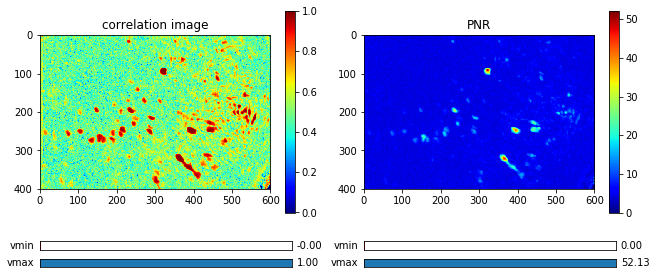

In [19]:
# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(Y, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter,pnr)


In [23]:
min_corr = .8 # min correlation of peak (from correlation image)
min_pnr = 10 # min peak to noise ratio
min_SNR = 3 # adaptive way to set threshold on the transient size
r_values_min = 0.85  # threshold on space consistency (if you lower more components will be accepted, potentially with worst quality)
decay_time = 0.4  #decay time of transients/indocator

In [20]:
m_orig = None

In [21]:
Y.shape

(1349, 400, 600)

In [24]:
cnm = cnmf.CNMF(n_processes=n_processes, 
                method_init='corr_pnr',                 # use this for 1 photon
                k=70,                                   # neurons per patch
                gSig=(6, 6),                            # half size of neuron
                gSiz=(19, 19),                          # in general 3*gSig+1
                merge_thresh=.8,                        # threshold for merging
                p=1,                                    # order of autoregressive process to fit
                dview=dview,                            # if None it will run on a single thread
                tsub=4,                                 # downsampling factor in time for initialization, increase if you have memory problems             
                ssub=4,                                 # downsampling factor in space for initialization, increase if you have memory problems
                Ain=None,                               # if you want to initialize with some preselcted components you can pass them here as boolean vectors
                rf=(40, 40),                            # half size of the patch (final patch will be 100x100)
                stride=(40, 40),                        # overlap among patches (keep it at least large as 4 times the neuron size)
                only_init_patch=True,                   # just leave it as is
                gnb=16,                                 # number of background components
                nb_patch=16,                            # number of background components per patch
                method_deconvolution='oasis',           #could use 'cvxpy' alternatively
                low_rank_background=True,               #leave as is
                update_background_components=True,      # sometimes setting to False improve the results
                min_corr=min_corr,                      # min peak value from correlation image 
                min_pnr=min_pnr,                        # min peak to noise ration from PNR image
                normalize_init=False,                   # just leave as is
                center_psf=True,                        # leave as is for 1 photon
                del_duplicates=True)                    # whether to remove duplicates from initialization

cnm.fit(Y)

(1349, 400, 600)
using 8 processes
using 4000 pixels per process
using 5000 block_size
(80, 80)
190.8713583946228
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background
Compressing background components with a low rank NMF
Generating background DONE
merging


/home/fpbatta/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[7 8]
No neurons merged!
update temporal


/home/fpbatta/src/extern/CaImAn_stable/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]


Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 20]
Transposing
Processed:[20, 40]
Transposing
Processed:[40, 48]
Transposing
entering the deconvolution 
38 out of total 78 temporal components updated
63 out of total 78 temporal components updated
74 out of total 78 temporal components updated
77 out of total 78 temporal components updated
78 out of total 78 temporal components updated
38 out of total 78 temporal components updated
63 out of total 78 temporal components updated
74 out of total 78 temporal components updated
77 out of total 78 temporal components updated
78 out of total 78 temporal components updated
stopping: overall temporal component not changing significantly
update spatial ...
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
parallel dot product block size: 5000
Start product
Processed:[0, 20]
Filling
P

/home/fpbatta/src/extern/CaImAn_stable/caiman/utils/visualization.py:941: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


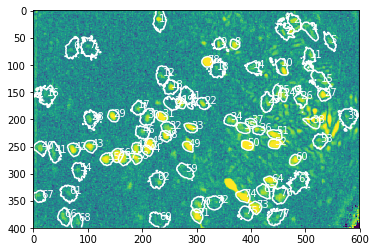

In [25]:
crd = cm.utils.visualization.plot_contours(cnm.A, cn_filter, thr=.8, vmax=0.95)

In [26]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, comp_SNR, r_values, pred_CNN = estimate_components_quality_auto(
                            Y, cnm.A, cnm.C, cnm.b, cnm.f, cnm.YrA, frate, 
                            decay_time, gSig, dims, dview = dview, 
                            min_SNR=min_SNR, r_values_min = r_values_min, min_std_reject = 0.5, use_cnn = False)

print(' ***** ')
print((len(cnm.C)))
print((len(idx_components)))
print(r_values[idx_components_bad])

EVALUATING IN PARALLEL... NOT RETURNING ERFCs
 ***** 
78
63
[-0.11712599 -0.32351679  0.12514267 -0.12372649  0.32304834 -0.04494266
  0.08846901 -0.43491306  0.22307661  0.08448417  0.2261721   0.10676433
  0.11202273 -0.34934714 -0.17591125]


/home/fpbatta/src/extern/CaImAn_stable/caiman/utils/visualization.py:941: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


Text(0.5,1,'Contour plots of rejected components')

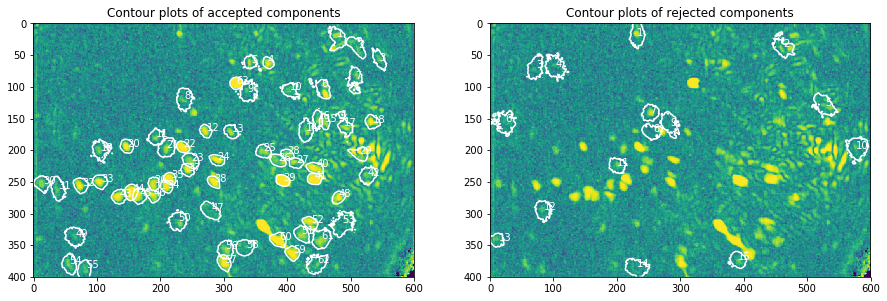

In [27]:
#%% PLOT COMPONENTS

plt.figure(figsize=(15,8));
plt.subplot(121);
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of accepted components')
plt.subplot(122); 
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components_bad], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of rejected components')

In [28]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons = cn_filter,
                denoised_color = 'red', thr=0.8, cmap='gray');

In [29]:
# rejected components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons = cn_filter,
                denoised_color = 'red', thr=0.8, cmap='gray');

In [30]:
cm.stop_server(dview=dview)

 done


### Movies

In [31]:
#%% denoised movie
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components])+cnm.b.dot(cnm.f),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 1.2)

In [33]:
#%% only neurons
neur_movie = cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components]),dims+(-1,), order = 'F').transpose(2,0,1))
neur_movie

neur_movie.play(magnification=1, gain = 10.)

In [34]:
neur_movie.save('neur_movie.tif')

.tif
tifffile package not found, using skimage instead for imsave


In [35]:
#%% only the background
cm.movie(np.reshape(cnm.b.dot(cnm.f),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 1.)

In [36]:
#%% residuals
cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+cnm.b.dot(cnm.f),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 10., fr = 10)